# <center> Project 3 | Thermal inspection (classifying the defects) of photovoltaic modules
<center> Faculty of Engineering, University of Porto Master in Data Science and Enginnering

<center> Francisco Cuervo up202302145 | Silvia Tavares up202204392.

<center> Computer Vision, November 2023

## Introduction

Photovoltaic modules, are devices that captures solar power to transform it into sustainable energy. A semiconductor material, usually silicon, is the basis of each individual solar cell. It is light sensitive and generates electricity when struck by the rays of the sun thanks to a physical phenomenon called the photovoltaic effect. Photovoltaic modules are made up of many individual, interconnected photovoltaic cells.

In recent years, there has been an exponential growth in photovoltaics across the world. This brings many problems associated with the quality of the systems due to several factors. The main problem is that all the photovoltaic modules look very similar although their quality is totally different. Defects on the modules are usually not visible by the naked eyes and also their causes should be found by the special methods. As a result, there are many installations that necessarily requires the regular monitoring. By observing the challenges involved with the PV modules and their operation, work can be carried toward the improvement in reliability and the service life of PV modules.

Thermal inspection plays a crucial role in the maintenance and performance assessment of photovoltaic (PV) modules. The process involves using infrared thermography to detect and classify defects in PV modules based on variations in temperature. This technique is valuable for identifying issues that may affect the efficiency and overall health of solar panels.


## Project Description

The goal of this project is to perform image classification of defects in photovoltaic modules that is a computer vision task that involves assigning a label or category to an input image based on its visual content.

In this context, image classification will be used to identify anomalies in photovoltaic modules using deep learning models, such as Convolutional Neural Networks (CNN) and Trafer Learning Models. This models have shown great promise in automating the defect classification process.

## Data Understanding

The dataset that is used for this project is the InfraredSolarModules dataset that is a machine learning dataset that contains real-world imagery of different anomalies found in solar farms and can be found at https://github.com/RaptorMaps/InfraredSolarModules.

The dataset consists of 20,000 infrared images that are 24 by 40 pixels each. There are 12 defined classes of solar modules presented with 11 classes of different anomalies and the remaining class being No-Anomaly (i.e. the null case).

The file contains the images directory and module_metadata.json that describes each image.

The 12 classes are :

| Class Name      | Images | Description                                              |
|-----------------|--------|----------------------------------------------------------|
| Cell            | 1,877  | Hot spot occurring with square geometry in single cell.  |
| Cell-Multi      | 1,288  | Hot spots occurring with square geometry in multiple cells. |
| Cracking        | 941    | Module anomaly caused by cracking on module surface.     |
| Hot-Spot        | 251    | Hot spot on a thin film module.                          |
| Hot-Spot-Multi  | 247    | Multiple hot spots on a thin film module.                |
| Shadowing       | 1,056  | Sunlight obstructed by vegetation, man-made structures, or adjacent rows. |
| Diode           | 1,499  | Activated bypass diode, typically 1/3 of module.         |
| Diode-Multi     | 175    | Multiple activated bypass diodes, typically affecting 2/3 of module. |
| Vegetation      | 1,639  | Panels blocked by vegetation.                            |
| Soiling         | 205    | Dirt, dust, or other debris on the surface of the module.|
| Offline-Module  | 828    | Entire module is heated.                                 |
| No-Anomaly      | 10,000 | Nominal solar module.                                    |



## Initial Setup

In [50]:
from google.colab import drive, files
import os
import numpy as np
import cv2
import glob
from google.colab.patches import cv2_imshow
import pandas as pd
from matplotlib import pyplot as plt
import copy
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD, NAdam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
def download_content(url):
  FOLDER_NAME_ZIP="data.zip"
  FOLDER_NAME="data"
  URL=url

  # Get .ZIP file
  !wget --quiet -O $FOLDER_NAME_ZIP "$URL" \
  && echo -e "Files downloaded successfully!      File: $FOLDER_NAME_ZIP"

  # Unzip folder
  !unzip -q -o -d $FOLDER_NAME $FOLDER_NAME_ZIP \
  && echo -e "Files extracted successfully!       Folder:$FOLDER_NAME"

  # Remove .ZIP file
  !rm -f $FOLDER_NAME_ZIP \
  && echo -e "File: $FOLDER_NAME_ZIP removed successfully!\n"

In [ ]:
URL="https://drive.google.com/uc?export=download&id=1BCrMwmF3gB_qCMol567RIWA3WMxkd8j2&confirm=t"
download_content(URL)

Files downloaded successfully!      File: data.zip
Files extracted successfully!       Folder:data
File: data.zip removed successfully!



In [ ]:
wdir = '/content/data/InfraredSolarModules'

In [2]:
# Execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


## Data Exploration

In [ ]:
metadata_file_path = os.path.join(wdir, 'module_metadata.json')

df = pd.read_json(metadata_file_path, orient='index').sort_index()
df['image_name'] = df['image_filepath']
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(wdir, x))
df

,image_filepath,anomaly_class,image_name
0,/content/data/InfraredSolarModules/images/0.jpg,Offline-Module,images/0.jpg
1,/content/data/InfraredSolarModules/images/1.jpg,Offline-Module,images/1.jpg
2,/content/data/InfraredSolarModules/images/2.jpg,Offline-Module,images/2.jpg
3,/content/data/InfraredSolarModules/images/3.jpg,Offline-Module,images/3.jpg
4,/content/data/InfraredSolarModules/images/4.jpg,Offline-Module,images/4.jpg
...,...,...,...
19995,/content/data/InfraredSolarModules/images/1999...,No-Anomaly,images/19995.jpg
19996,/content/data/InfraredSolarModules/images/1999...,No-Anomaly,images/19996.jpg
19997,/content/data/InfraredSolarModules/images/1999...,No-Anomaly,images/19997.jpg
19998,/content/data/InfraredSolarModules/images/1999...,No-Anomaly,images/19998.jpg


In [ ]:
df.describe()

,image_filepath,anomaly_class,image_name
count,20000,20000,20000
unique,20000,12,20000
top,/content/data/InfraredSolarModules/images/0.jpg,No-Anomaly,images/0.jpg
freq,1,10000,1


In [ ]:
# Create a new DataFrame with anomaly_class and number_of_instances
df_instances = pd.DataFrame(df['anomaly_class'].value_counts().reset_index())
df_instances.columns = ['anomaly_class', 'number_of_instances']

# Display the new DataFrame
df_instances

,anomaly_class,number_of_instances
0,No-Anomaly,10000
1,Cell,1877
2,Vegetation,1639
3,Diode,1499
4,Cell-Multi,1288
5,Shadowing,1056
6,Cracking,940
7,Offline-Module,827
8,Hot-Spot,249
9,Hot-Spot-Multi,246


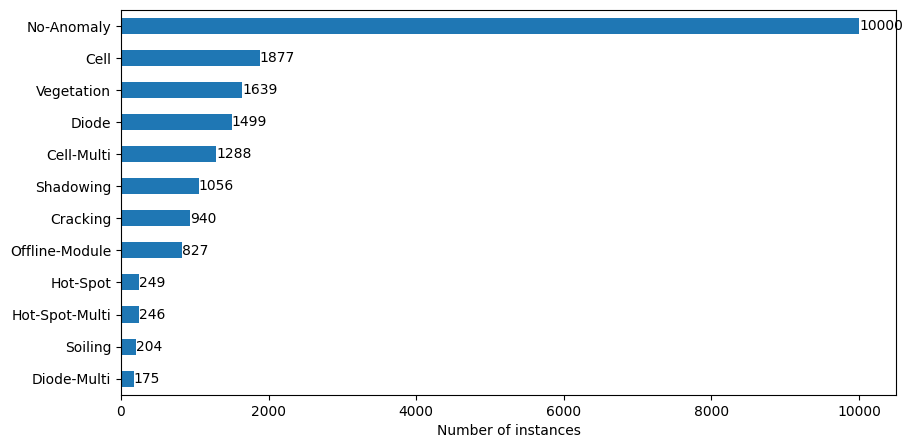

In [ ]:
ax = df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

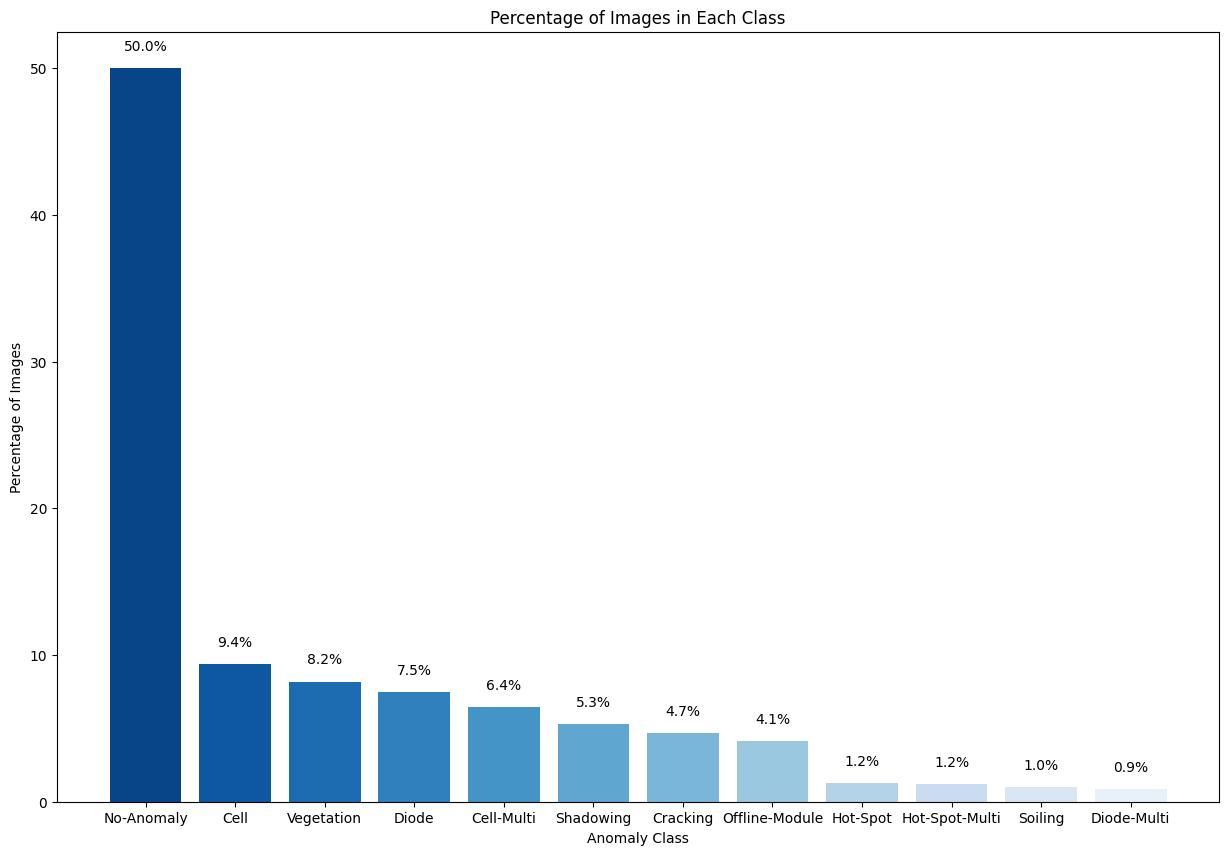

In [ ]:
# Calculate the total number of instances
total_instances = df_instances['number_of_instances'].sum()

# Calculate the percentage of images for each class
df_instances['percentage'] = (df_instances['number_of_instances'] / total_instances) * 100

# Sort the DataFrame by 'percentage' in descending order
df_instances_sorted = df_instances.sort_values(by='percentage', ascending=False)

# Define a reversed color palette for the classes from darker to lighter blue
class_palette = sns.color_palette("Blues", n_colors=len(df_instances_sorted))[::-1]

# Plotting a bar chart for percentage of instances in each class with a class-specific color palette
plt.figure(figsize=(15, 10))
plt.bar(df_instances_sorted['anomaly_class'], df_instances_sorted['percentage'], color=class_palette)

# Adding labels and title
plt.xlabel('Anomaly Class')
plt.ylabel('Percentage of Images')
plt.title('Percentage of Images in Each Class')

# Display percentage values on top of each bar
for i, percentage in enumerate(df_instances_sorted['percentage']):
    plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()


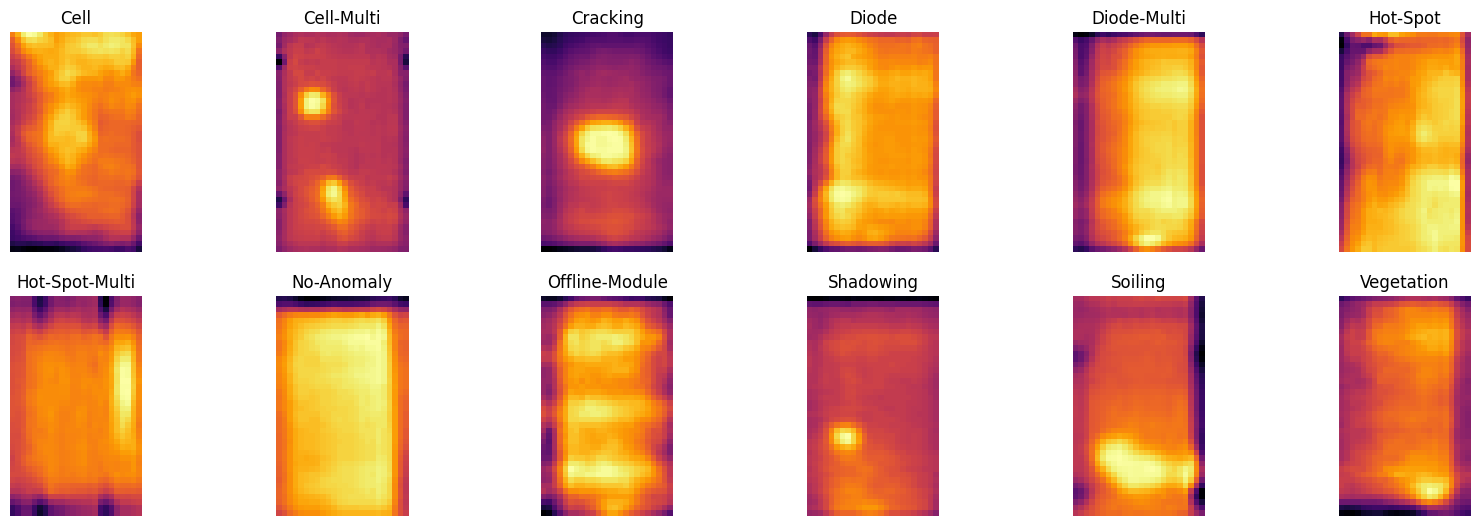

In [ ]:
sample = df.groupby('anomaly_class').apply(lambda x: x.sample())

plt.figure(figsize=(20,20))
for i, row in enumerate(sample.itertuples(), start=1):
    image_path = row.image_filepath
    class_name = row.anomaly_class

    image = cv2.imread(image_path, 0)

    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')
plt.show()

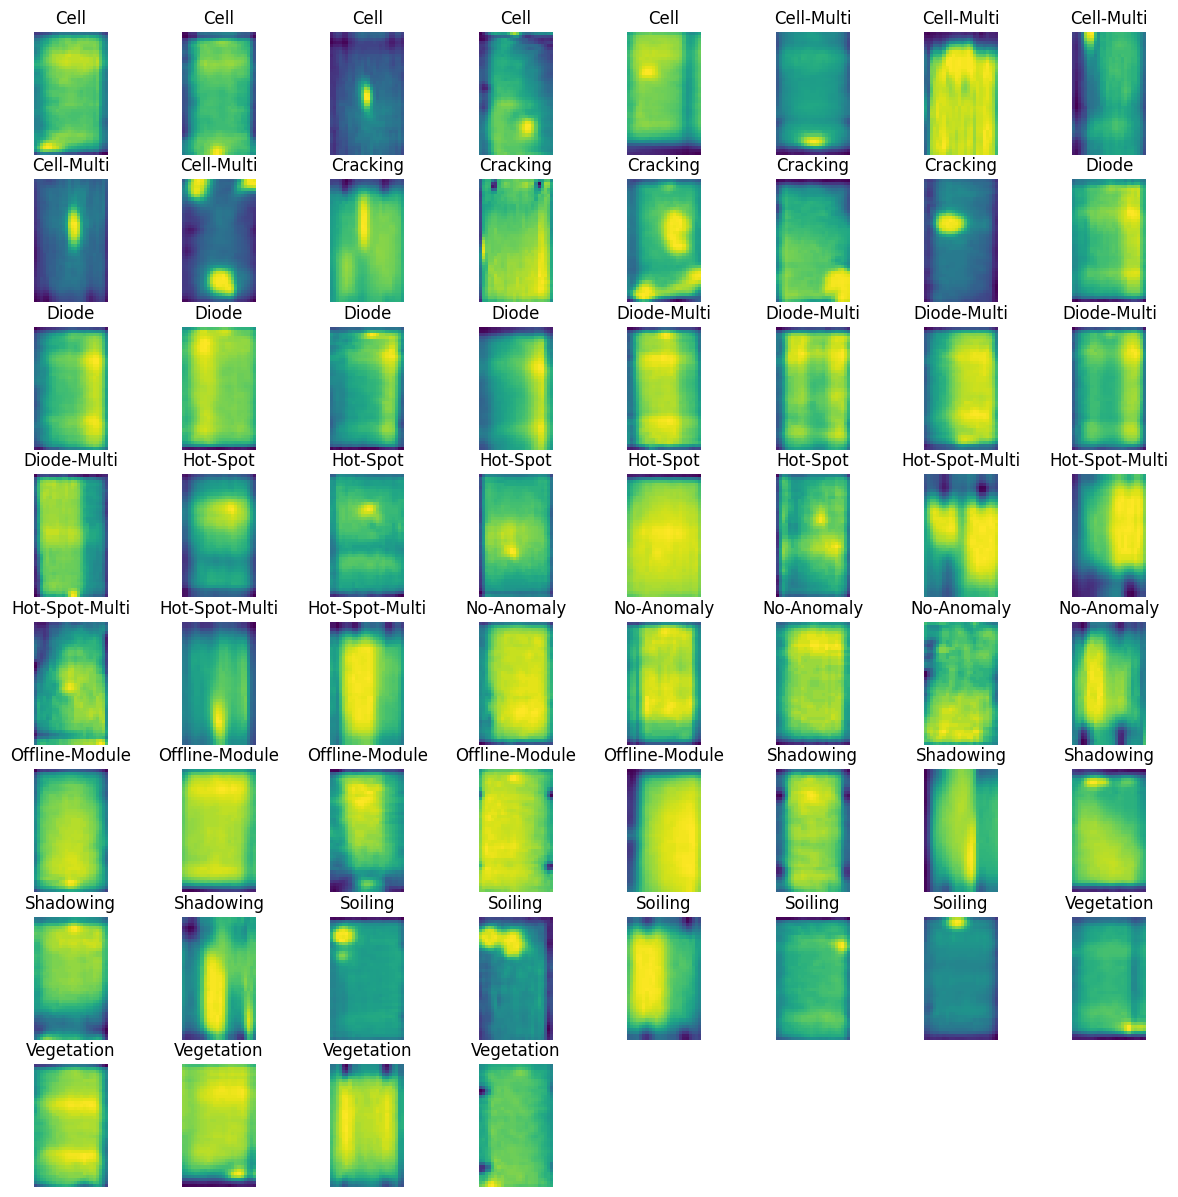

In [ ]:
sample = df.groupby('anomaly_class').apply(lambda x: x.sample(5))

plt.figure(figsize=(15,15))
for i, row in enumerate(sample.itertuples(), start=1):
    image_path = row.image_filepath
    class_name = row.anomaly_class

    image = cv2.imread(image_path, 0)

    plt.subplot(8, 8, i)
    plt.imshow(image) #cmap='inferno' cmap='gray'
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [ ]:
# Choose the first image in the sample
first_image_path = sample.iloc[0]['image_filepath']
first_image = cv2.imread(first_image_path, 0)

# Get the dimensions of the first image
height, width = first_image.shape

# Print the dimensions
print(f"Image Dimensions: Height={height}, Width={width}")


Image Dimensions: Height=40, Width=24


##Modeling

In [ ]:
mapping = {
    "Cell": 0, "Cell-Multi": 1, "Cracking": 2, "Hot-Spot": 3,
    "Hot-Spot-Multi": 4, "Shadowing": 5, "Diode": 6,
    "Diode-Multi": 7, "Vegetation": 8, "Soiling": 9,
    "Offline-Module": 10, "No-Anomaly": 11
}

# Map the values in the 'anomaly_class' column using the dictionary
df['anomaly_class'] = df['anomaly_class'].map(mapping)

# Convert the column to integer type
df['anomaly_class'] = df['anomaly_class'].astype(int)

In [ ]:
df['anomaly_class']

0        10
1        10
2        10
3        10
4        10
         ..
19995    11
19996    11
19997    11
19998    11
19999    11
Name: anomaly_class, Length: 20000, dtype: int64

### Data Balancing

In [ ]:
class DataBalance:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def count_anomaly_rows(self):
        counts = self.dataframe['anomaly_class'].value_counts()
        return counts

    def balanced_data(self):
        counts = self.count_anomaly_rows()

        for anomaly_class, count in counts.items():
            if count < 500:
                self.add_rows(anomaly_class, count, factor=6)
            elif 500 <= count < 1000:
                self.add_rows(anomaly_class, count, factor=1.2)
            elif count > 5000:
                self.remove_rows(anomaly_class, count, num_to_remove=8300)

        # Return the augmented dataframe
        return self.dataframe

    def add_rows(self, anomaly_class, count, factor):
        num_new_rows = int(count * (factor - 1))  # Calculate the number of new rows to add
        # Duplicate existing rows with the specified anomaly_class
        duplicated_rows = self.dataframe[self.dataframe['anomaly_class'] == anomaly_class].sample(n=num_new_rows, replace=True)

        # Append the duplicated rows to the dataframe
        self.dataframe = pd.concat([self.dataframe, duplicated_rows], ignore_index=True)

    def remove_rows(self, anomaly_class, count, num_to_remove):
        # Identify rows to remove
        rows_to_remove = np.random.choice(self.dataframe.index[self.dataframe['anomaly_class'] == anomaly_class], num_to_remove, replace=False)

        # Remove selected rows from the dataframe
        self.dataframe = self.dataframe.drop(rows_to_remove)


In [ ]:
data_balancer = DataBalance(df)

# Display counts before augmentation
print("Before Balancing:")
print(data_balancer.count_anomaly_rows())

# Augment the data and get the augmented dataframe
df = data_balancer.balanced_data()

# Display counts after augmentation
print("\nAfter Balancing:")
print(data_balancer.count_anomaly_rows())


Before Balancing:
11    10000
0      1877
8      1639
6      1499
1      1288
5      1056
2       940
10      827
3       249
4       246
9       204
7       175
Name: anomaly_class, dtype: int64

After Balancing:
0     1877
11    1700
8     1639
6     1499
3     1494
4     1476
1     1288
9     1224
2     1127
5     1056
7     1050
10     992
Name: anomaly_class, dtype: int64


In [ ]:
df = df[['image_filepath', 'anomaly_class']].dropna()

In [ ]:
df.isnull().sum()

image_filepath    0
anomaly_class     0
dtype: int64

In [ ]:
# Create a new DataFrame with anomaly_class and number_of_instances
df_instances = pd.DataFrame(df['anomaly_class'].value_counts().reset_index())
df_instances.columns = ['anomaly_class', 'number_of_instances']

# Display the new DataFrame
df_instances

,anomaly_class,number_of_instances
0,0,1877
1,11,1700
2,8,1639
3,6,1499
4,3,1494
5,4,1476
6,1,1288
7,9,1224
8,2,1127
9,5,1056


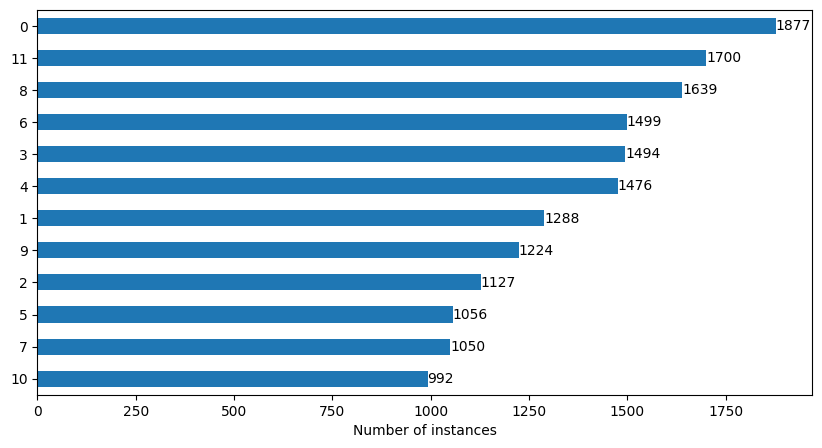

In [ ]:
ax = df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()


### Data model


Data Augmentation (transform):
- Transform to tensor: Converts the PIL Image to a PyTorch tensor.
- Normalization: Normalizes the tensor by subtracting the mean (0.5) and dividing by the standard deviation (0.5).
- Random Rotation: Randomly rotates the image by an angle within the specified range (-20 to 20 degrees).

Rotation helps introduce variability to the training set, preventing overfitting and improving the model's generalization to unseen data.


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)

        # Ensure the image is in 'RGB' mode before converting to grayscale
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Convert image to grayscale (1 channel)
        image = image.convert('L')

        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# Data Augmentation: - transform to Tensor, Rotate and Normalize

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
    transforms.RandomRotation(degrees=(-20, 20)),
])

# Split the dataset into train and test
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Further split the training set into train and validation
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)

train_dataset = CustomDataset(dataframe=df.loc[train_idx], root_dir= wdir, transform=transform)
val_dataset = CustomDataset(dataframe=df.loc[val_idx], root_dir= wdir, transform=transform)
test_dataset = CustomDataset(dataframe=df.loc[test_idx], root_dir= wdir, transform=transform)

batch_size = 128

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 11823
Validation size: 1314
Test size: 3285


In [ ]:
# Print the number of batches in each DataLoader
print(f"Number of batches in trainloader: {len(trainloader)}")
print(f"Number of batches in valloader: {len(valloader)}")
print(f"Number of batches in testloader: {len(testloader)}")

Number of batches in trainloader: 93
Number of batches in valloader: 11
Number of batches in testloader: 26


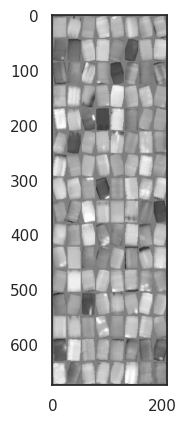

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize'
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

### Defining a CNN model

The following model architecture consists of four convolutional layers with batch normalization and max-pooling operations. The final layers include global average pooling, followed by two fully connected layers for classification.

**Convolutional Layers (Conv2d):**

- Four convolutional layers with increasing numbers of filters (80, 160, 320, 640).
- Each layer uses a kernel size of 3x3, a stride of 1, and padding of 1 to maintain spatial dimensions.

**Batch Normalization (BatchNorm2d):**

- Batch normalization is applied after each convolutional layer to normalize the input to the subsequent layers.

**Max Pooling (MaxPool2d):**

- Four max-pooling layers with a kernel size of 2x2 and a stride of 2, reducing spatial dimensions.

**Global Average Pooling (AdaptiveAvgPool2d):**

- A global average pooling layer reduces the spatial dimensions to 1x1, creating a vector of values for each filter.

**Fully Connected Layers (Linear):**

- Two fully connected layers with 640 input features ( the last layer's output) and 512 neurons in the first layer.
- The final layer has 12 neurons, 12 classes for anomaly prediction.

**Activation Function (ReLU):**

- Rectified Linear Unit (ReLU) activation functions are applied after each convolutional layer and the first fully connected layer.

**Forward Method:**

- The forward method defines the forward pass through the network, specifying the sequence of operations.
- Convolutional and pooling layers are followed by batch normalization and ReLU activation.
- The final output is obtained after global average pooling and passing through the fully connected layers.



In [ ]:
class PVModuleCNN(nn.Module):
    def __init__(self):
        super(PVModuleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 80, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(80)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(80, 160, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(160)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(160, 320, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(320)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(320, 640, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(640)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(640, 512)
        self.fc2 = nn.Linear(512, 12)  # 12 classes for anomaly prediction

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = self.global_avg_pooling(x)
        x = x.view(-1, 640)  # Flatten for fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Create an instance of the model
model = PVModuleCNN().to(device)

### Defining a Loss function

Loss function based on Cross-Entropy loss and an
Stochastic Gradient Descent (SGD) Optimizer.

SGD is an iterative method for optimizing an objective function with suitable smoothness properties. It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate calculated from a randomly selected subset of the data.


In [ ]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9)

### Prepare the model Training



In [ ]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    if is_train:
        model.train()
    else:
        model.eval()

    all_predictions = []
    all_targets = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if is_train:
            optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        if is_train:
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Update loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        # Collect predictions and targets for F1 score calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = correct_predictions / total_samples
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Calculate average loss
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, f1

In [ ]:
def train_and_validate(model, model_name, train_dataloader, validation_dataloader, loss_fn, optimizer, num_epochs ):
    train_history = {'loss': [], 'accuracy': [], 'f1_score': []}
    val_history = {'loss': [], 'accuracy': [], 'f1_score': []}
    best_val_loss = np.inf
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_epoch = 0

    print("Start training...")
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}/{num_epochs}")
        train_loss, train_acc, train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
        print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f} \t Train F1: {train_f1:.3f}")

        val_loss, val_acc, val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
        print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f} \t Val F1: {val_f1:.3f}")

        # Save model when val loss or accuracy improves
        if val_loss < best_val_loss or val_acc > best_val_acc:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_epoch = t

            save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
            torch.save(save_dict, model_name + '_best_model.pth')

        # Save latest model
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_latest_model.pth')

        # Save training history for plotting purposes
        train_history["loss"].append(train_loss)
        train_history["accuracy"].append(train_acc)
        train_history["f1_score"].append(train_f1)

        val_history["loss"].append(val_loss)
        val_history["accuracy"].append(val_acc)
        val_history["f1_score"].append(val_f1)

    print("Finished")

    return train_history, val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch

In [ ]:
model_name = 'cnn'
# Call the train_and_validate function
train_history, val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(model, model_name, trainloader, valloader, loss_fn, optimizer, num_epochs=35)

print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {val_history['f1_score'][best_epoch]:.3f}")

Start training...

Epoch 1/35
Train loss: 2.039 	 Train acc: 0.317 	 Train F1: 0.294
Val loss: 1.737 	 Val acc: 0.421 	 Val F1: 0.418

Epoch 2/35
Train loss: 1.581 	 Train acc: 0.463 	 Train F1: 0.452
Val loss: 1.530 	 Val acc: 0.491 	 Val F1: 0.479

Epoch 3/35
Train loss: 1.381 	 Train acc: 0.535 	 Train F1: 0.525
Val loss: 1.376 	 Val acc: 0.538 	 Val F1: 0.512

Epoch 4/35
Train loss: 1.271 	 Train acc: 0.562 	 Train F1: 0.555
Val loss: 1.335 	 Val acc: 0.540 	 Val F1: 0.526

Epoch 5/35
Train loss: 1.168 	 Train acc: 0.599 	 Train F1: 0.590
Val loss: 1.278 	 Val acc: 0.563 	 Val F1: 0.561

Epoch 6/35
Train loss: 1.085 	 Train acc: 0.623 	 Train F1: 0.616
Val loss: 1.153 	 Val acc: 0.608 	 Val F1: 0.604

Epoch 7/35
Train loss: 1.031 	 Train acc: 0.643 	 Train F1: 0.637
Val loss: 1.137 	 Val acc: 0.610 	 Val F1: 0.602

Epoch 8/35
Train loss: 0.970 	 Train acc: 0.664 	 Train F1: 0.660
Val loss: 1.025 	 Val acc: 0.648 	 Val F1: 0.643

Epoch 9/35
Train loss: 0.931 	 Train acc: 0.681 	 Tra

### Analyse training evolution

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

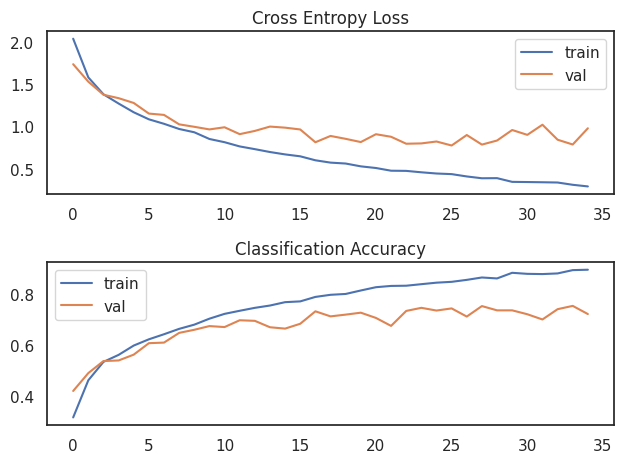

In [ ]:
plotTrainingHistory(train_history, val_history)

### Testing CNN

In [ ]:
# Load the model
model = PVModuleCNN().to(device)
checkpoint = torch.load('cnn_best_model.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
import matplotlib.pyplot as plt


def test_model(model, testloader, loss_fn):
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    all_probs = []  # to store probability scores for AUC calculation

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation during testing
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Get probabilities and store them for AUC calculation
            softmax_probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(softmax_probs.cpu().numpy())

    accuracy = correct_predictions / total_samples

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # F1-score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    all_probs_np = np.array(all_probs)  # Convert all_probs to a NumPy array

    for i in range(12):
        fpr[i], tpr[i], _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs_np[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return {
        'loss': test_loss / len(testloader),
        'accuracy': accuracy,
        'f1_score': f1,
        'conf_matrix': conf_matrix,
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

# Test the model
test_metrics = test_model(model, testloader, loss_fn)

print(f"Test Loss: {test_metrics['loss']:.3f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.3f}")
print(f"Test F1-score: {test_metrics['f1_score']:.3f}")

Test Loss: 0.751
Test Accuracy: 0.753
Test F1-score: 0.754


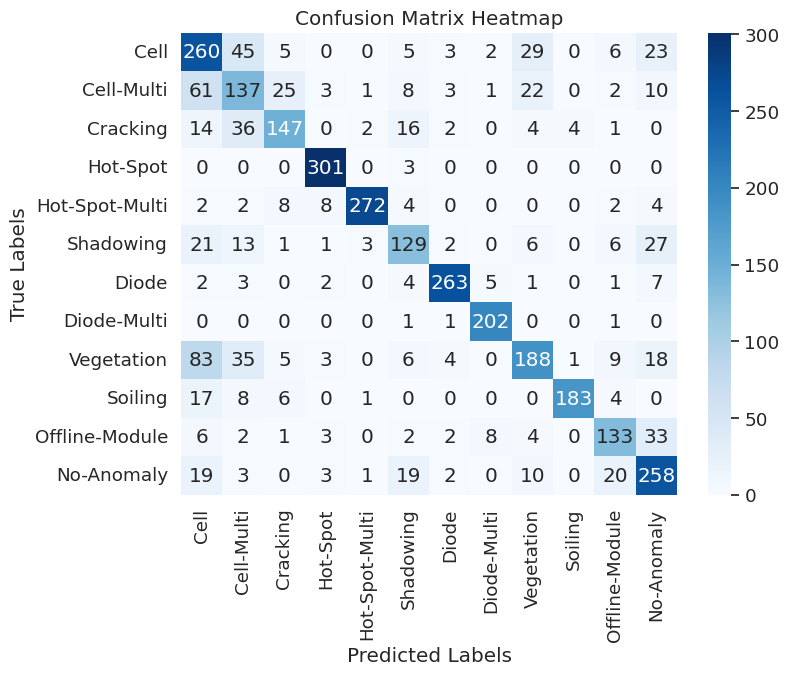

In [ ]:
# Generate a confusion matrix heatmap
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size for better readability
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

class_names = [ "Cell", "Cell-Multi", "Cracking", "Hot-Spot",
    "Hot-Spot-Multi", "Shadowing", "Diode",
    "Diode-Multi", "Vegetation", "Soiling",
    "Offline-Module", "No-Anomaly"]

test_conf_matrix = test_metrics['conf_matrix']

# Plot the confusion matrix heatmap
plot_confusion_matrix(test_conf_matrix, class_names)


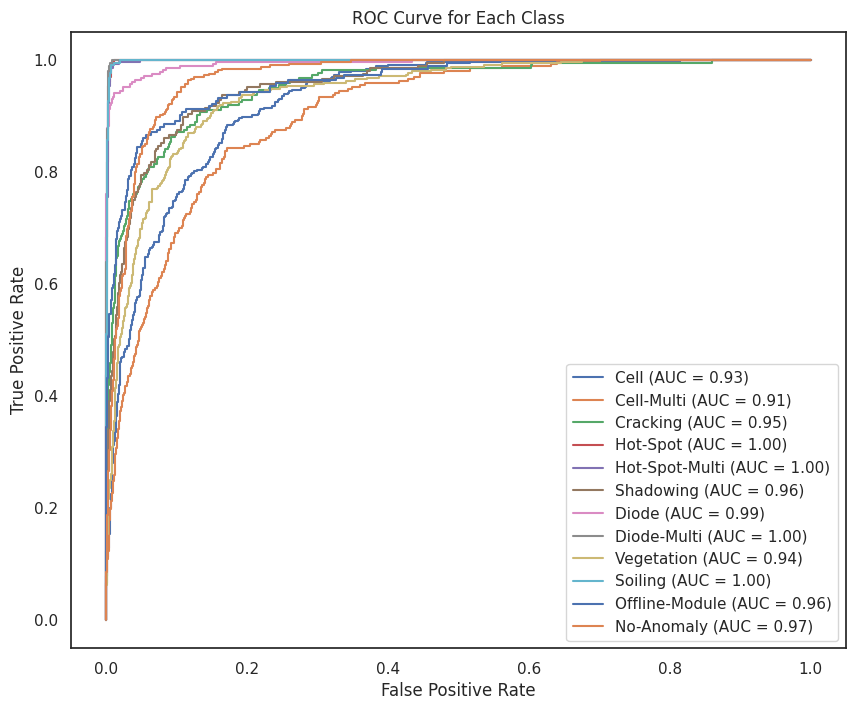

In [ ]:
# Plot ROC curves for each class
sns.set(style='white')
plt.figure(figsize=(10, 8))

for label, class_name in enumerate(class_names):
    try:
        plt.plot(test_metrics['fpr'][label], test_metrics['tpr'][label], label=f'{class_name} (AUC = {test_metrics["auc"][label]:.2f})')
    except KeyError:
        print(f"Class '{class_name}' not found in test_metrics. Skipping.")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
def showErrors(model, dataloader, num_examples=20):
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

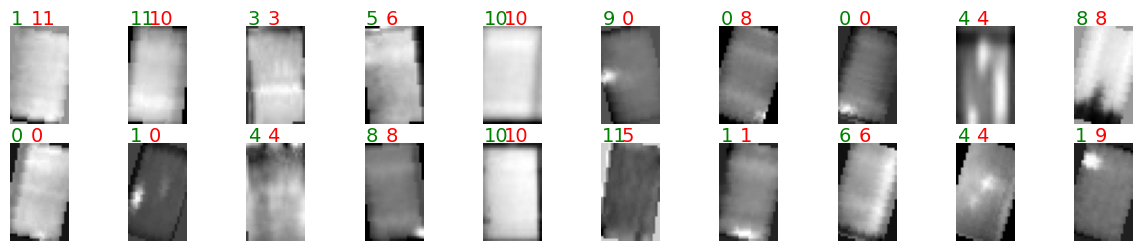

In [ ]:
showErrors(model, testloader)

### Comparing AI model with Tranfer Learning Models

In [ ]:

# Split the data into train and test
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Further split the training set into train and validation
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')  # Ensure the image is in RGB format
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Adjust for 3 channels
    transforms.RandomRotation(degrees=(-20, 20)),
])

train_dataset = CustomDataset(dataframe=df.loc[train_idx], root_dir = wdir, transform=transform)
val_dataset = CustomDataset(dataframe=df.loc[val_idx], root_dir = wdir, transform=transform)
test_dataset = CustomDataset(dataframe=df.loc[test_idx], root_dir = wdir, transform=transform)

batch_size = 128

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


####ResNet
ResNet-50 model.

In [ ]:
# load model from torchvision (with pretrained=True)
resnet = models.resnet50(pretrained=True)

# change the number of neurons in the last layer to the number of classes of the problem
resnet.fc = nn.Linear(resnet.fc.in_features, 12)

resnet.to(device)
print(resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
num_epochs = 35
model_name = 'resnet50'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr = 0.005)

resnet_train_history, resnet_val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(resnet, model_name,trainloader, valloader, loss_fn, optimizer_resnet, num_epochs)

print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {resnet_val_history['f1_score'][best_epoch]:.3f}")

Start training...

Epoch 1/35
Train loss: 0.373 	 Train acc: 0.874 	 Train F1: 0.877
Val loss: 0.760 	 Val acc: 0.752 	 Val F1: 0.753

Epoch 2/35
Train loss: 0.326 	 Train acc: 0.891 	 Train F1: 0.895
Val loss: 0.691 	 Val acc: 0.773 	 Val F1: 0.771

Epoch 3/35
Train loss: 0.302 	 Train acc: 0.898 	 Train F1: 0.902
Val loss: 0.686 	 Val acc: 0.780 	 Val F1: 0.779

Epoch 4/35
Train loss: 0.261 	 Train acc: 0.913 	 Train F1: 0.916
Val loss: 0.770 	 Val acc: 0.758 	 Val F1: 0.757

Epoch 5/35
Train loss: 0.249 	 Train acc: 0.919 	 Train F1: 0.922
Val loss: 0.720 	 Val acc: 0.775 	 Val F1: 0.774

Epoch 6/35
Train loss: 0.228 	 Train acc: 0.926 	 Train F1: 0.929
Val loss: 0.768 	 Val acc: 0.771 	 Val F1: 0.766

Epoch 7/35
Train loss: 0.216 	 Train acc: 0.931 	 Train F1: 0.934
Val loss: 0.810 	 Val acc: 0.763 	 Val F1: 0.765

Epoch 8/35
Train loss: 0.191 	 Train acc: 0.937 	 Train F1: 0.939
Val loss: 0.827 	 Val acc: 0.750 	 Val F1: 0.753

Epoch 9/35
Train loss: 0.177 	 Train acc: 0.945 	 Tra

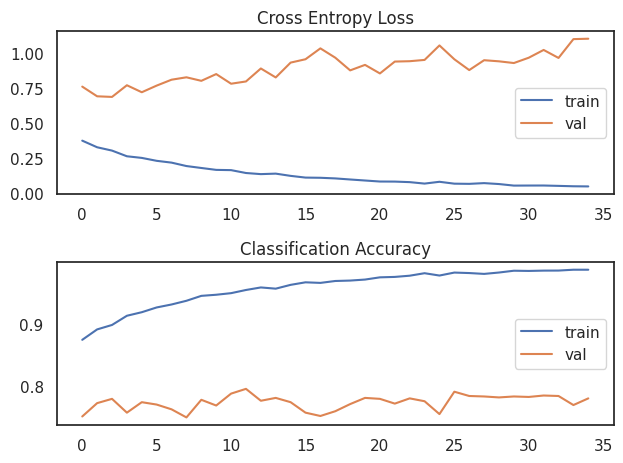

In [ ]:
plotTrainingHistory(resnet_train_history, resnet_val_history)

In [ ]:
# Load the model
resnet = resnet.to(device)
checkpoint = torch.load('resnet50_best_model.pth')
resnet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
# final code for resnet
resnet.eval()
total = 0
correct = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        probs = torch.nn.functional.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 80.61%


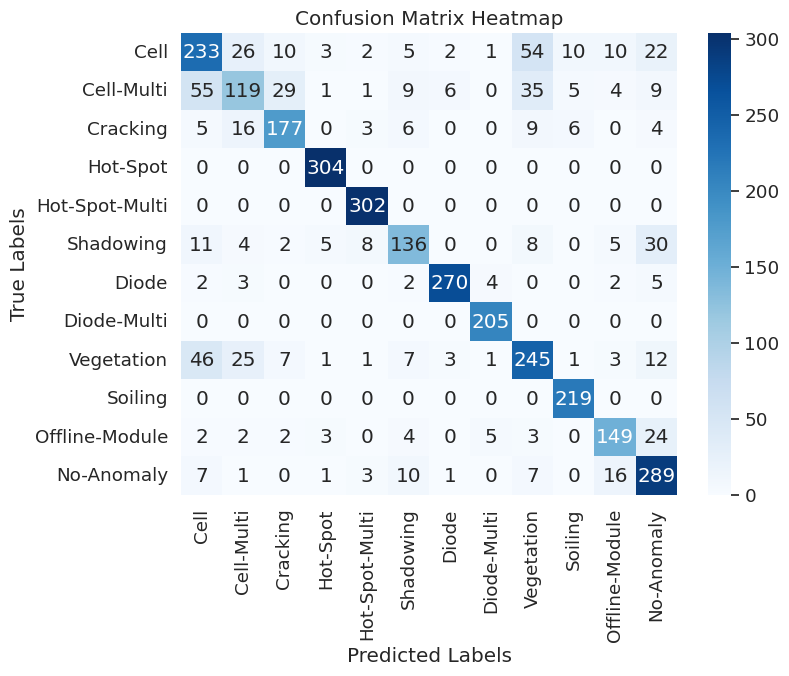

In [ ]:
# Create a confusion matrix
test_conf_matrix = confusion_matrix(all_labels, all_preds)
# Plot the confusion matrix heatmap
plot_confusion_matrix(test_conf_matrix, class_names)

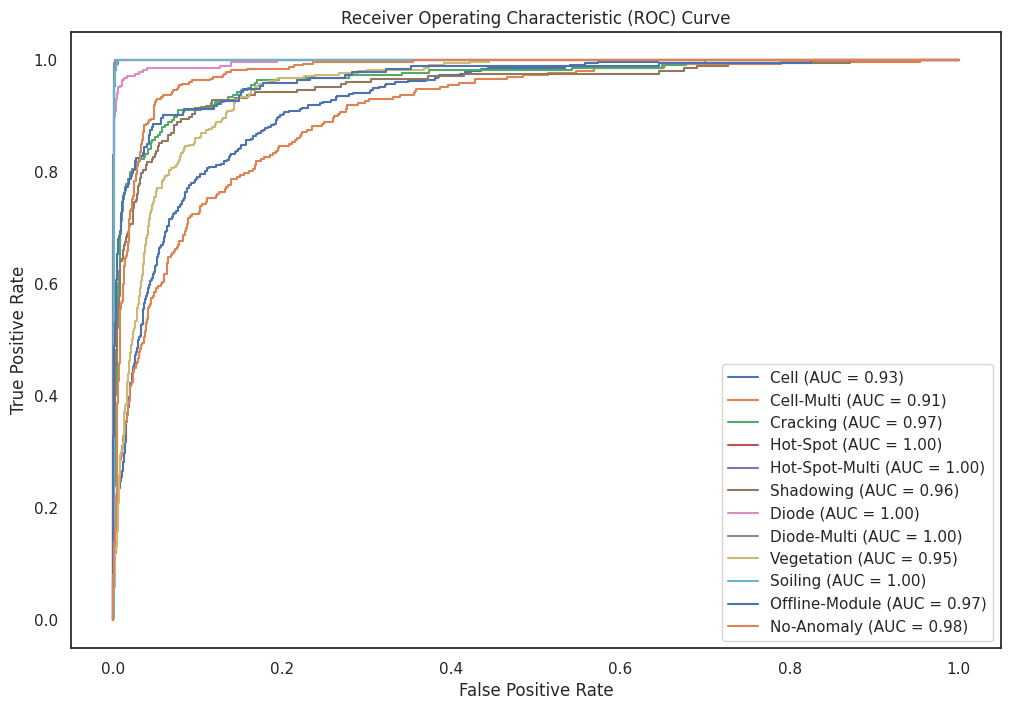

In [ ]:
def plot_auc(labels, predicted_probs, class_names):
    sns.set(style='white')  # Use a white style without a grid

    plt.figure(figsize=(12, 8))

    for i in range(len(class_names)):
        true_labels = label_binarize(labels, classes=list(range(len(class_names))))[:, i]
        pred_probs = predicted_probs[:, i]
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


# Plot AUC for each label
plot_auc(all_labels, np.array(all_probs), class_names)


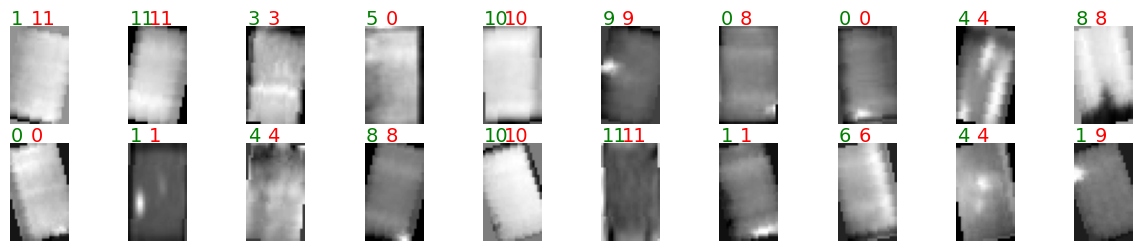

In [ ]:
showErrors(resnet,testloader)

####MobileNet

In [ ]:
num_classes = 12

# Load pre-trained MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_ftrs = mobilenet_v2.classifier[1].in_features
mobilenet_v2.classifier[1] = nn.Linear(num_ftrs, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match MobileNetV2 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(dataframe=df.loc[train_idx], root_dir = wdir, transform=transform)
val_dataset = CustomDataset(dataframe=df.loc[val_idx], root_dir = wdir, transform=transform)
test_dataset = CustomDataset(dataframe=df.loc[test_idx], root_dir = wdir, transform=transform)

# Create data loaders
batch_size = 64
num_workers = 2
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 98.0MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_v2.parameters(), lr=0.005)

# Move the model to the specified device
mobilenet_v2 = mobilenet_v2.to(device)

num_epochs = 35
model_name = 'mobilenet_v2'
mobilenet_v2_train_history, mobilenet_v2_val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(
    mobilenet_v2, model_name, trainloader, valloader, criterion, optimizer, num_epochs)

Start training...

Epoch 1/35
Train loss: 1.847 	 Train acc: 0.385 	 Train F1: 0.362
Val loss: 1.668 	 Val acc: 0.447 	 Val F1: 0.430

Epoch 2/35
Train loss: 1.391 	 Train acc: 0.518 	 Train F1: 0.497
Val loss: 1.812 	 Val acc: 0.408 	 Val F1: 0.367

Epoch 3/35
Train loss: 1.279 	 Train acc: 0.550 	 Train F1: 0.535
Val loss: 1.796 	 Val acc: 0.436 	 Val F1: 0.395

Epoch 4/35
Train loss: 1.189 	 Train acc: 0.581 	 Train F1: 0.568
Val loss: 1.335 	 Val acc: 0.551 	 Val F1: 0.535

Epoch 5/35
Train loss: 1.106 	 Train acc: 0.619 	 Train F1: 0.607
Val loss: 1.201 	 Val acc: 0.598 	 Val F1: 0.584

Epoch 6/35
Train loss: 1.050 	 Train acc: 0.635 	 Train F1: 0.626
Val loss: 1.390 	 Val acc: 0.527 	 Val F1: 0.510

Epoch 7/35
Train loss: 0.984 	 Train acc: 0.658 	 Train F1: 0.649
Val loss: 1.293 	 Val acc: 0.579 	 Val F1: 0.558

Epoch 8/35
Train loss: 0.930 	 Train acc: 0.675 	 Train F1: 0.668
Val loss: 1.242 	 Val acc: 0.594 	 Val F1: 0.571

Epoch 9/35
Train loss: 0.861 	 Train acc: 0.700 	 Tra

In [ ]:
print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {val_history['f1_score'][best_epoch]:.3f}")

Best validation accuracy: 0.755
Best validation loss: 1.040
Best validation F1-score: 0.754
F1-score at the best epoch (35): 0.736


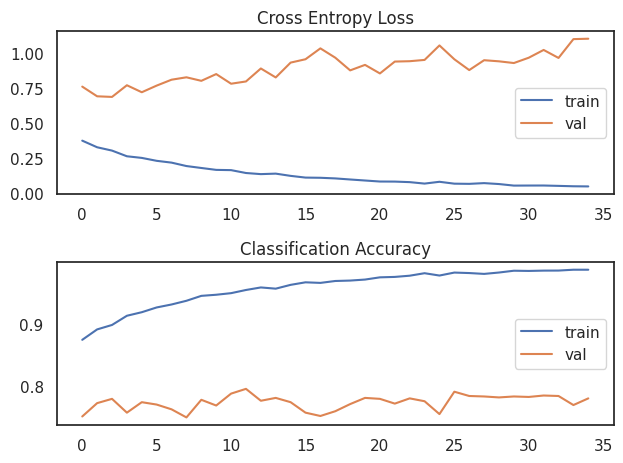

In [ ]:
plotTrainingHistory(mobilenet_v2_train_history, mobilenet_v2_val_history)

In [ ]:
# Load the model
mobilenet_v2 = mobilenet_v2.to(device)
checkpoint = torch.load('mobilenet_v2_best_model.pth')
mobilenet_v2.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
mobilenet_v2.eval()

total_loss = 0.0
correct_predictions = 0
total_samples = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = mobilenet_v2(inputs)
        loss = criterion(outputs, targets)

        _, predicted = torch.max(outputs, 1)
        total_loss += loss.item()
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_accuracy = correct_predictions / total_samples
test_loss = total_loss / len(testloader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.9983
Test Accuracy: 76.23%


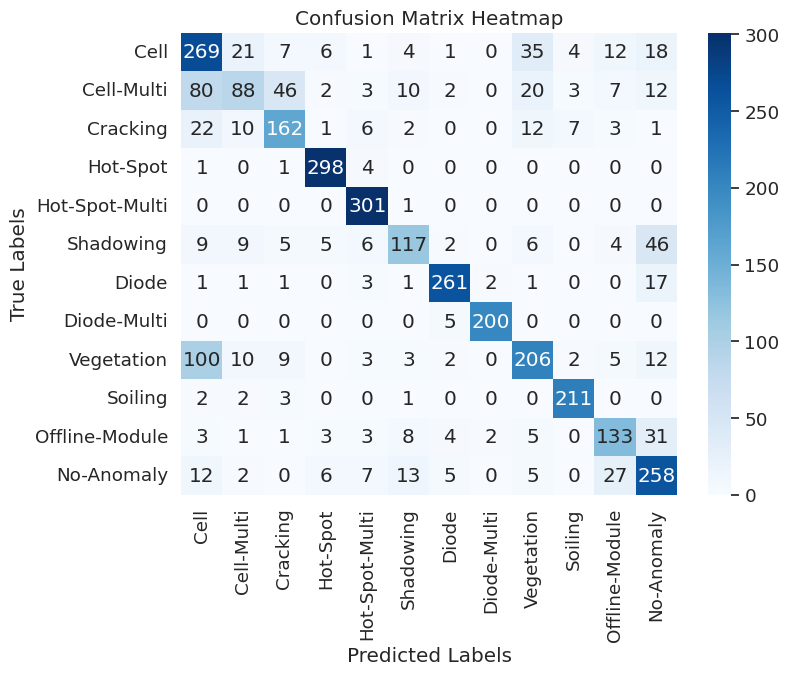

In [ ]:
test_conf_matrix = confusion_matrix(all_targets, all_predictions)

# Plot the confusion matrix heatmap
plot_confusion_matrix(test_conf_matrix, class_names)

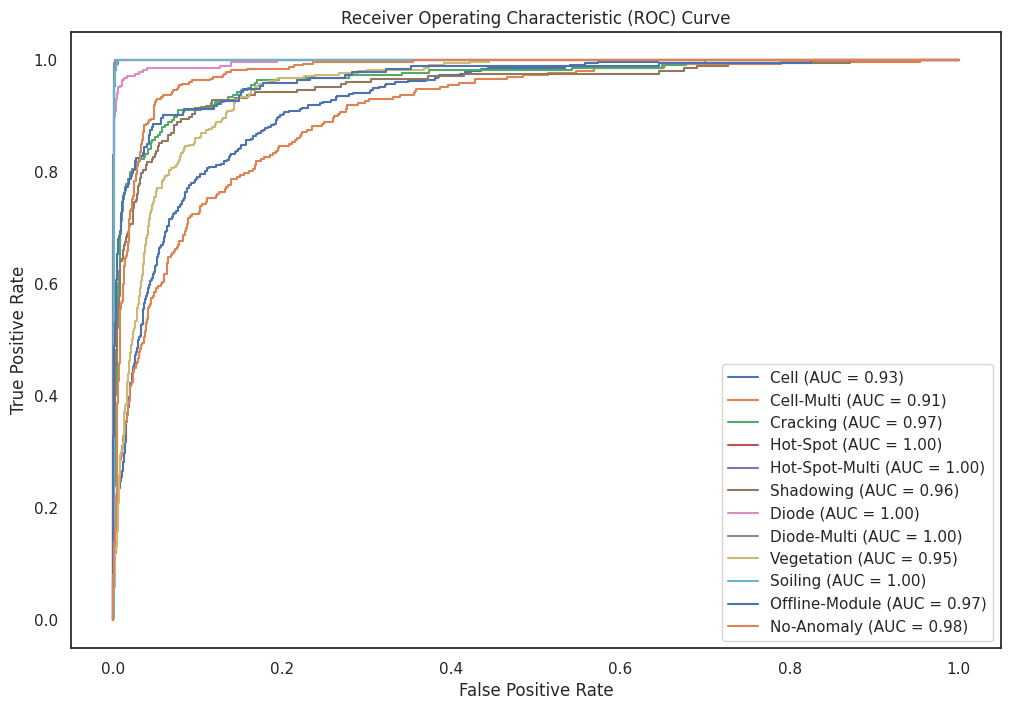

In [ ]:
# Plot AUC for each label
plot_auc(all_labels, np.array(all_probs), class_names)

####SqueezeNet

In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match the input size expected by SqueezeNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images using SqueezeNet's mean and std
])

train_dataset = CustomDataset(dataframe=df.loc[train_idx], root_dir = wdir, transform=transform)
val_dataset = CustomDataset(dataframe=df.loc[val_idx], root_dir = wdir, transform=transform)
test_dataset = CustomDataset(dataframe=df.loc[test_idx], root_dir = wdir, transform=transform)

# Create data loaders
batch_size = 64
num_workers = 2

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained SqueezeNet model
squeezenet = models.squeezenet1_1(pretrained=True)

# Modify the final fully connected layer
num_classes = 12
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Move the model to the device
squeezenet = squeezenet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(squeezenet.parameters(), lr=0.005, momentum=0.9)

In [ ]:
model_name = 'squeezenet'
squeezenet_train_history, squeezenet_val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(
    squeezenet, model_name, trainloader, valloader, criterion, optimizer, num_epochs)

print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {squeezenet_val_history['f1_score'][best_epoch]:.3f}")

Start training...

Epoch 1/35
Train loss: 2.329 	 Train acc: 0.183 	 Train F1: 0.157
Val loss: 2.130 	 Val acc: 0.249 	 Val F1: 0.198

Epoch 2/35
Train loss: 1.920 	 Train acc: 0.337 	 Train F1: 0.321
Val loss: 1.784 	 Val acc: 0.447 	 Val F1: 0.426

Epoch 3/35
Train loss: 1.701 	 Train acc: 0.413 	 Train F1: 0.400
Val loss: 1.583 	 Val acc: 0.466 	 Val F1: 0.458

Epoch 4/35
Train loss: 1.533 	 Train acc: 0.473 	 Train F1: 0.462
Val loss: 1.406 	 Val acc: 0.524 	 Val F1: 0.517

Epoch 5/35
Train loss: 1.397 	 Train acc: 0.519 	 Train F1: 0.508
Val loss: 1.317 	 Val acc: 0.559 	 Val F1: 0.544

Epoch 6/35
Train loss: 1.280 	 Train acc: 0.565 	 Train F1: 0.557
Val loss: 1.433 	 Val acc: 0.511 	 Val F1: 0.499

Epoch 7/35
Train loss: 1.201 	 Train acc: 0.588 	 Train F1: 0.580
Val loss: 1.296 	 Val acc: 0.559 	 Val F1: 0.550

Epoch 8/35
Train loss: 1.127 	 Train acc: 0.611 	 Train F1: 0.607
Val loss: 1.175 	 Val acc: 0.594 	 Val F1: 0.579

Epoch 9/35
Train loss: 1.045 	 Train acc: 0.640 	 Tra

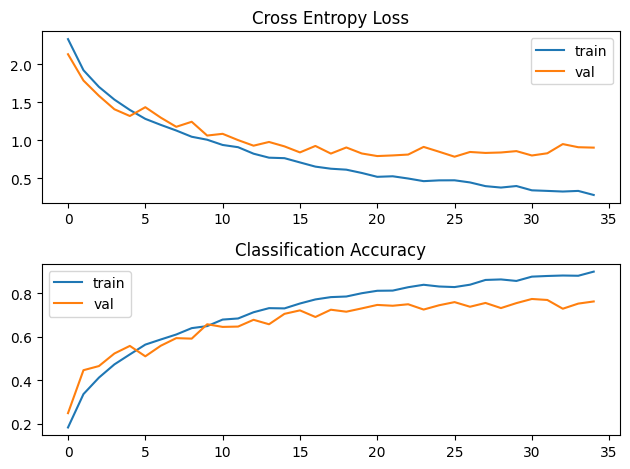

In [ ]:
plotTrainingHistory(squeezenet_train_history, squeezenet_val_history)

In [ ]:
# Load the model
densenet = squeezenet.to(device)
checkpoint = torch.load('squeezenet_best_model.pth')
squeezenet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
# Test the model
squeezenet.eval()
total = 0
correct = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = squeezenet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        probs = torch.nn.functional.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 77.05%


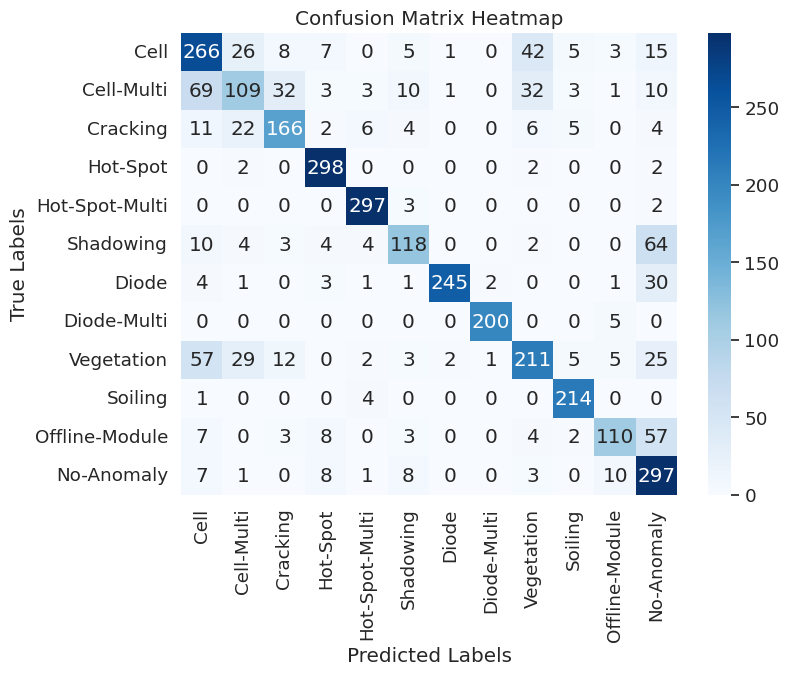

In [ ]:
# Create a confusion matrix
test_conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix heatmap
plot_confusion_matrix(test_conf_matrix, class_names)

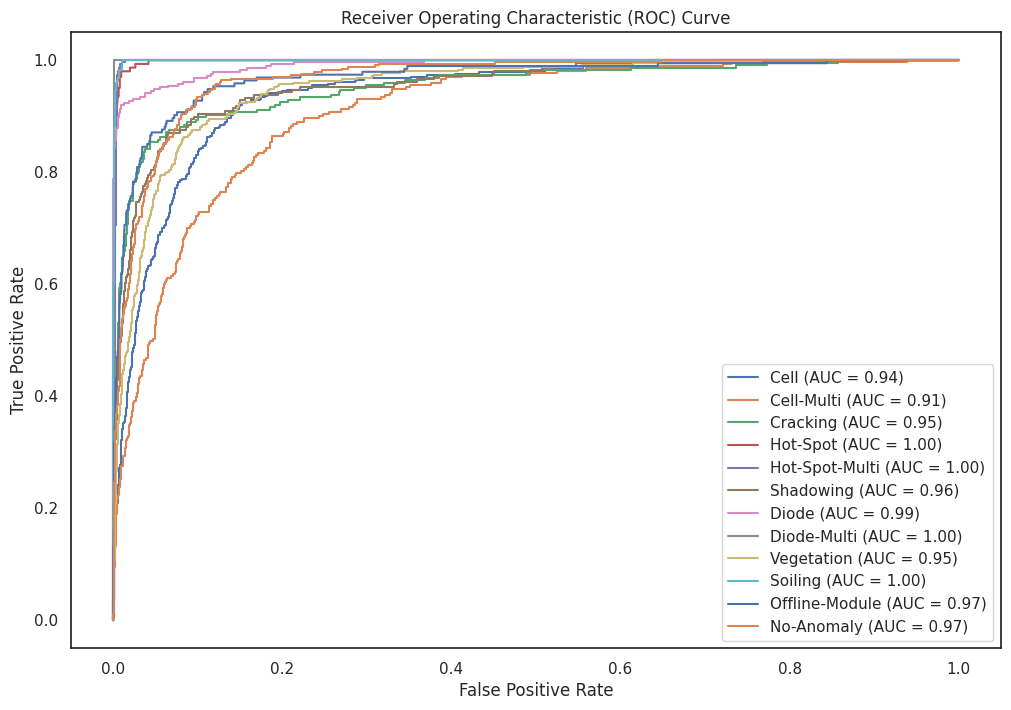

In [ ]:
# Plot AUC for each label
plot_auc(all_labels, np.array(all_probs), class_names)

####DenseNet

In [ ]:
# Load pre-trained DenseNet model
densenet = models.densenet121(pretrained=True)
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)

# Move the model to the device
densenet = densenet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(densenet.parameters(), lr=0.005, momentum=0.9)

num_epochs = 15
model_name = 'densenet'
densenet_train_history, densenet_val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(
    densenet, model_name, trainloader, valloader, criterion, optimizer, num_epochs)

print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {densenet_val_history['f1_score'][best_epoch]:.3f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training...

Epoch 1/15
Train loss: 1.465 	 Train acc: 0.500 	 Train F1: 0.487
Val loss: 1.124 	 Val acc: 0.623 	 Val F1: 0.618

Epoch 2/15
Train loss: 0.829 	 Train acc: 0.718 	 Train F1: 0.714
Val loss: 0.973 	 Val acc: 0.661 	 Val F1: 0.659

Epoch 3/15
Train loss: 0.573 	 Train acc: 0.803 	 Train F1: 0.801
Val loss: 0.730 	 Val acc: 0.772 	 Val F1: 0.764

Epoch 4/15
Train loss: 0.440 	 Train acc: 0.845 	 Train F1: 0.845
Val loss: 0.679 	 Val acc: 0.773 	 Val F1: 0.775

Epoch 5/15
Train loss: 0.321 	 Train acc: 0.887 	 Train F1: 0.888
Val loss: 1.163 	 Val acc: 0.634 	 Val F1: 0.628

Epoch 6/15
Train loss: 0.266 	 Train acc: 0.906 	 Train F1: 0.907
Val loss: 0.837 	 Val acc: 0.758 	 Val F1: 0.753

Epoch 7/15
Train loss: 0.202 	 Train acc: 0.931 	 Train F1: 0.933
Val loss: 0.733 	 Val acc: 0.790 	 Val F1: 0.790

Epoch 8/15
Train loss: 0.133 	 Train acc: 0.957 	 Train F1: 0.959
Val loss: 0.768 	 Val acc: 0.789 	 Val F1: 0.792

Epoch 9/15
Train loss: 0.096 	 Train acc: 0.969 	 Tra

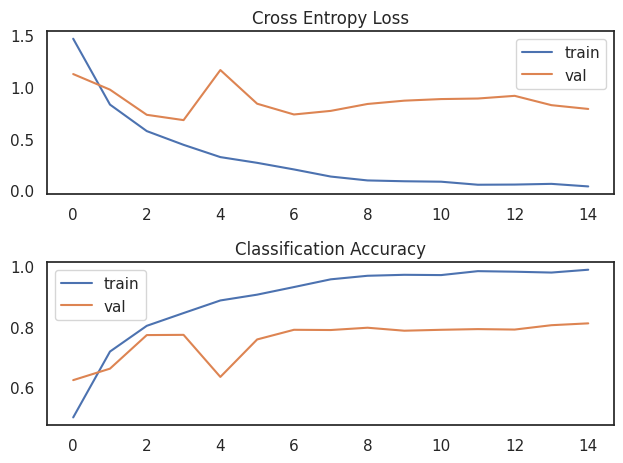

In [ ]:
plotTrainingHistory(densenet_train_history, densenet_val_history)

In [ ]:
# Load the model
densenet = densenet.to(device)
checkpoint = torch.load('densenet_best_model.pth')
densenet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
# Test the model
densenet.eval()
total = 0
correct = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        probs = torch.nn.functional.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 82.89%


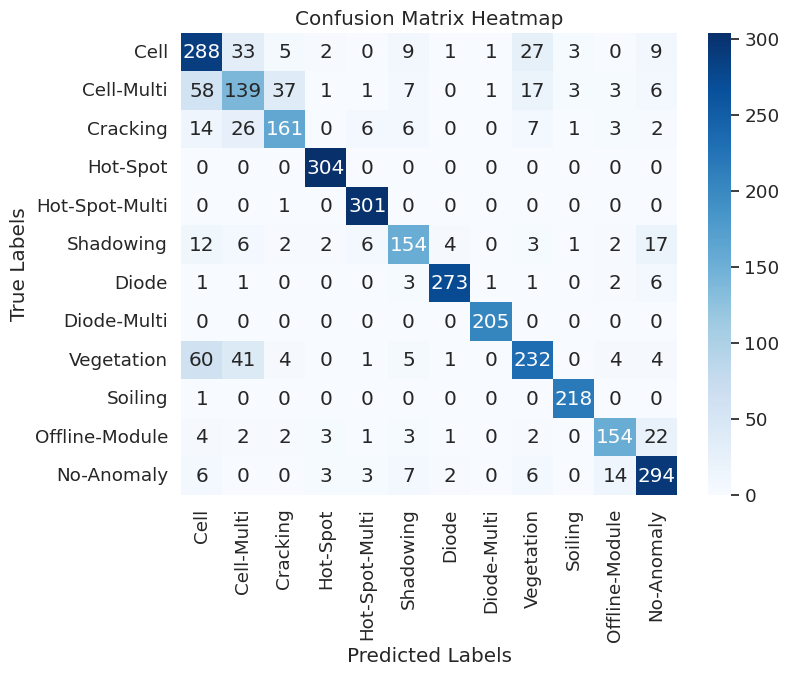

In [ ]:
# Create a confusion matrix
test_conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix heatmap
plot_confusion_matrix(test_conf_matrix, class_names)

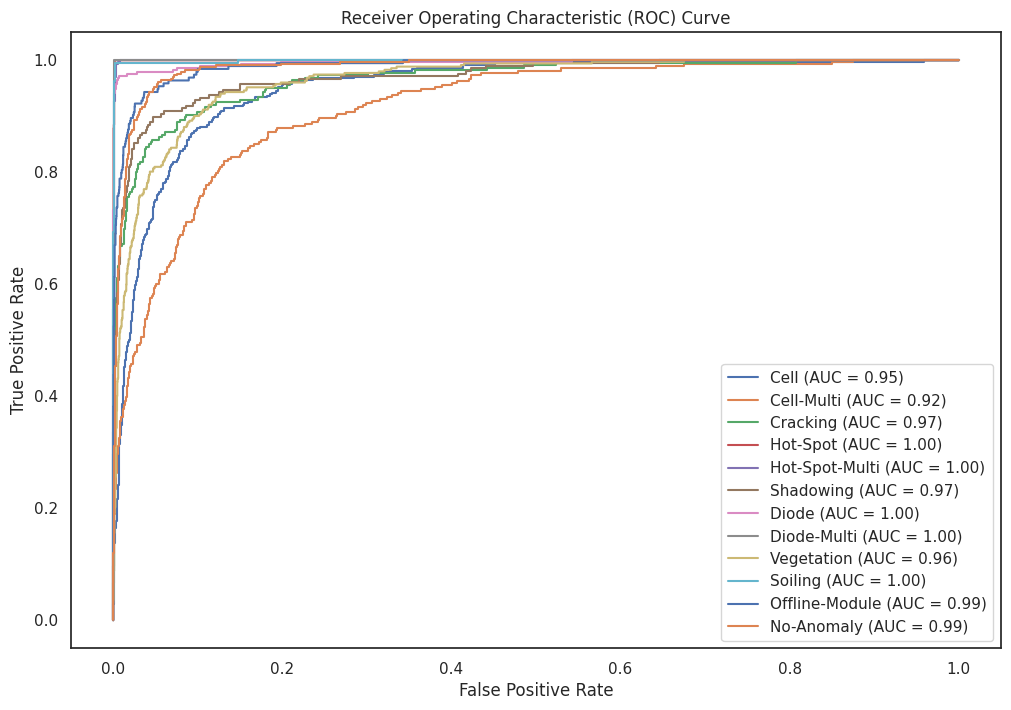

In [ ]:
# Plot AUC for each label
plot_auc(all_labels, np.array(all_probs), class_names)

####EfficientNet

In [ ]:
#!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

# Load pre-trained EfficientNet model (B0 variant)
efficientnet = EfficientNet.from_pretrained("efficientnet-b0", num_classes=12)

# Move the model to the device
efficientnet = efficientnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)

Loaded pretrained weights for efficientnet-b0


In [ ]:
num_epochs = 15
model_name = 'efficientnet'
efficientnet_train_history, efficientnet_val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(
    efficientnet, model_name, trainloader, valloader, criterion, optimizer, num_epochs)

print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {efficientnet_val_history['f1_score'][best_epoch]:.3f}")

Start training...

Epoch 1/15
Train loss: 1.197 	 Train acc: 0.596 	 Train F1: 0.585
Val loss: 2.403 	 Val acc: 0.107 	 Val F1: 0.071

Epoch 2/15
Train loss: 0.717 	 Train acc: 0.752 	 Train F1: 0.747
Val loss: 2.155 	 Val acc: 0.399 	 Val F1: 0.378

Epoch 3/15
Train loss: 0.537 	 Train acc: 0.816 	 Train F1: 0.813
Val loss: 0.924 	 Val acc: 0.705 	 Val F1: 0.697

Epoch 4/15
Train loss: 0.424 	 Train acc: 0.847 	 Train F1: 0.847
Val loss: 0.817 	 Val acc: 0.730 	 Val F1: 0.733

Epoch 5/15
Train loss: 0.348 	 Train acc: 0.875 	 Train F1: 0.875
Val loss: 0.875 	 Val acc: 0.767 	 Val F1: 0.763

Epoch 6/15
Train loss: 0.273 	 Train acc: 0.905 	 Train F1: 0.905
Val loss: 0.872 	 Val acc: 0.769 	 Val F1: 0.764

Epoch 7/15
Train loss: 0.204 	 Train acc: 0.928 	 Train F1: 0.929
Val loss: 1.167 	 Val acc: 0.701 	 Val F1: 0.706

Epoch 8/15
Train loss: 0.208 	 Train acc: 0.928 	 Train F1: 0.927
Val loss: 1.013 	 Val acc: 0.755 	 Val F1: 0.761

Epoch 9/15
Train loss: 0.147 	 Train acc: 0.949 	 Tra

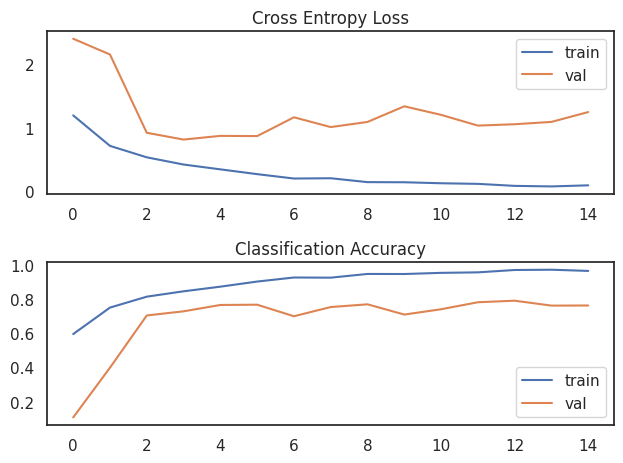

In [ ]:
plotTrainingHistory(efficientnet_train_history, efficientnet_val_history)

In [ ]:
# Load the model
efficientnet = efficientnet.to(device)
checkpoint = torch.load('efficientnet_best_model.pth')
efficientnet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
# Test the model
efficientnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = efficientnet(inputs)
        loss = criterion(outputs, targets)

        _, predicted = torch.max(outputs, 1)
        total_loss += loss.item()
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_accuracy = correct_predictions / total_samples
test_loss = total_loss / len(testloader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.9282
Test Accuracy: 81.19%


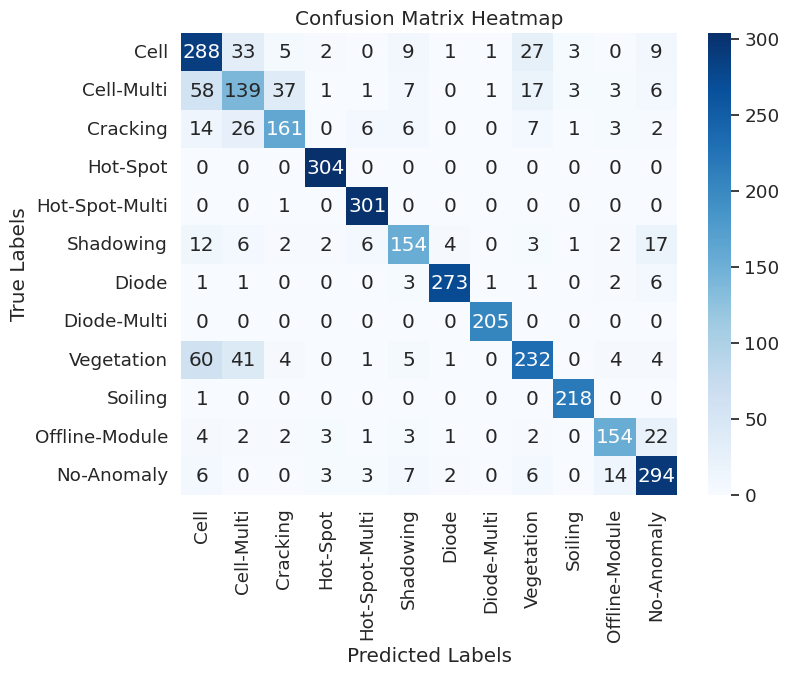

In [ ]:
# Create a confusion matrix
test_conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix heatmap
plot_confusion_matrix(test_conf_matrix, class_names)

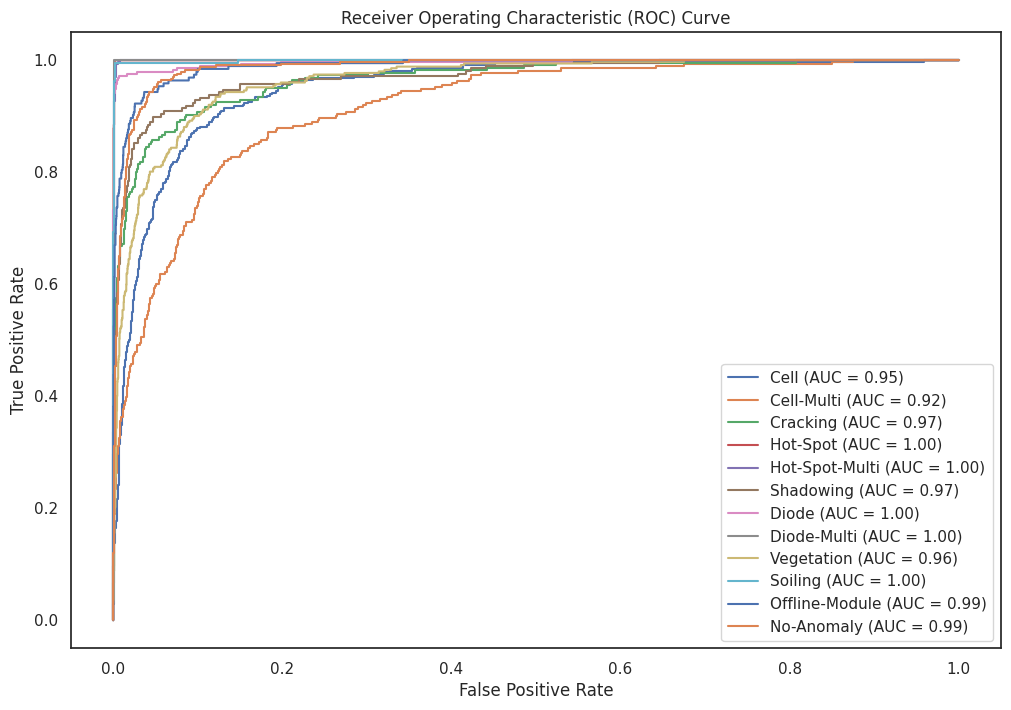

In [ ]:
# Plot AUC for each label
plot_auc(all_labels, np.array(all_probs), class_names)

**Comparing Number of Parameters**

In [ ]:
summary(model, (1, 40, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 80, 40, 24]             800
       BatchNorm2d-2           [-1, 80, 40, 24]             160
         MaxPool2d-3           [-1, 80, 20, 12]               0
            Conv2d-4          [-1, 160, 20, 12]         115,360
       BatchNorm2d-5          [-1, 160, 20, 12]             320
         MaxPool2d-6           [-1, 160, 10, 6]               0
            Conv2d-7           [-1, 320, 10, 6]         461,120
       BatchNorm2d-8           [-1, 320, 10, 6]             640
         MaxPool2d-9            [-1, 320, 5, 3]               0
           Conv2d-10            [-1, 640, 5, 3]       1,843,840
      BatchNorm2d-11            [-1, 640, 5, 3]           1,280
        MaxPool2d-12            [-1, 640, 2, 1]               0
AdaptiveAvgPool2d-13            [-1, 640, 1, 1]               0
           Linear-14                  [

In [ ]:
summary(resnet, (3, 40, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 20, 12]           9,408
       BatchNorm2d-2           [-1, 64, 20, 12]             128
              ReLU-3           [-1, 64, 20, 12]               0
         MaxPool2d-4            [-1, 64, 10, 6]               0
            Conv2d-5            [-1, 64, 10, 6]           4,096
       BatchNorm2d-6            [-1, 64, 10, 6]             128
              ReLU-7            [-1, 64, 10, 6]               0
            Conv2d-8            [-1, 64, 10, 6]          36,864
       BatchNorm2d-9            [-1, 64, 10, 6]             128
             ReLU-10            [-1, 64, 10, 6]               0
           Conv2d-11           [-1, 256, 10, 6]          16,384
      BatchNorm2d-12           [-1, 256, 10, 6]             512
           Conv2d-13           [-1, 256, 10, 6]          16,384
      BatchNorm2d-14           [-1, 256

In [ ]:
summary(mobilenet_v2, (3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
#summary(densenet, (3, 224, 224))
# Count the number of trainable and non-trainable parameters
total_params = sum(p.numel() for p in densenet.parameters())
trainable_params = sum(p.numel() for p in densenet.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")


Total Parameters: 6966156
Trainable Parameters: 6966156
Non-Trainable Parameters: 0


In [ ]:
summary(squeezenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [ ]:
summary(efficientnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

## Results

The CNN model seems to perform well, with a high accuracy and F1-score on both the training and validation sets.
The training loss, accuracy, and F1-score are close to the validation metrics, indicating that the model is not overfitting.
The best epoch is 34, where the model achieves the best validation performance with accuracy of 75.4%, 0.786 for loss, 0.761 of F1-Score and for Training, 0.309 for loss, 89.4% of accuracy and 0.897 of F1-Score. When testing the CNN an accuracy of 75.3%, a loss of 0.751 and was F1-Score of 0.754 obtained.  

In [47]:
values = [
    {'Model': 'CNN', 'Number of epochs': 35, 'Best epoch': 34, 'Train Accuracy': 89.4, 'Validation Accuracy': 75.4, 'Test Accuracy': 75.3, 'Train Loss': 0.309, 'Validation Loss': 0.786, 'Train F1-Score': 0.897, 'Validation F1-Score': 0.761, 'Trainable params': 2757868, 'Non-Trainable params': 0},
    {'Model': 'ResNet', 'Number of epochs': 35, 'Best epoch': 12, 'Train Accuracy': 95.4, 'Validation Accuracy': 79.6, 'Test Accuracy': 80.61, 'Train Loss': 0.141, 'Validation Loss': 0.797, 'Train F1-Score': 0.957, 'Validation F1-Score': 0.795, 'Trainable params': 23532620, 'Non-Trainable params': 0},
    {'Model': 'MobileNet', 'Number of epochs': 35, 'Best epoch': 35, 'Train Accuracy': 91.8, 'Validation Accuracy': 75.5, 'Test Accuracy': 76.23, 'Train Loss': 0.340, 'Validation Loss': 0.798, 'Train F1-Score': 0.919, 'Validation F1-Score': 0.754, 'Trainable params': 2239244,'Non-Trainable params': 0},
    {'Model': 'SqueezeNet', 'Number of epochs': 35, 'Best epoch': 31, 'Train Accuracy': 87.8, 'Validation Accuracy': 77.5, 'Test Accuracy': 77.05, 'Train Loss': 0.340, 'Validation Loss': 0.798, 'Train F1-Score': 0.880, 'Validation F1-Score': 0.880, 'Trainable params': 728652, 'Non-Trainable params': 0},
    {'Model': 'DenseNet', 'Number of epochs': 15, 'Best epoch': 15, 'Train Accuracy': 98.9, 'Validation Accuracy': 81.1, 'Test Accuracy': 82.89, 'Train Loss': 0.038, 'Validation Loss': 0.787, 'Train F1-Score': 0.989, 'Validation F1-Score': 0.814, 'Trainable params': 6966156, 'Non-Trainable params': 0},
    {'Model': 'EfficientNet', 'Number of epochs': 15, 'Best epoch': 13, 'Train Accuracy': 97.3, 'Validation Accuracy': 79.2, 'Test Accuracy': 81.19, 'Train Loss': 0.088, 'Validation Loss': 1.058, 'Train F1-Score': 0.973, 'Validation F1-Score': 0.792, 'Trainable params': 4022920, 'Non-Trainable params': 0}
]

results = pd.DataFrame(values)
results

,Model,Number of epochs,Best epoch,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Train F1-Score,Validation F1-Score,Trainable params,Non-Trainable params
0,CNN,35,34,89.4,75.4,75.30,0.309,0.786,0.897,0.761,2757868,0
1,ResNet,35,12,95.4,79.6,80.61,0.141,0.797,0.957,0.795,23532620,0
2,MobileNet,35,35,91.8,75.5,76.23,0.340,0.798,0.919,0.754,2239244,0
3,SqueezeNet,35,31,87.8,77.5,77.05,0.340,0.798,0.880,0.880,728652,0
4,DenseNet,15,15,98.9,81.1,82.89,0.038,0.787,0.989,0.814,6966156,0
5,EfficientNet,15,13,97.3,79.2,81.19,0.088,1.058,0.973,0.792,4022920,0


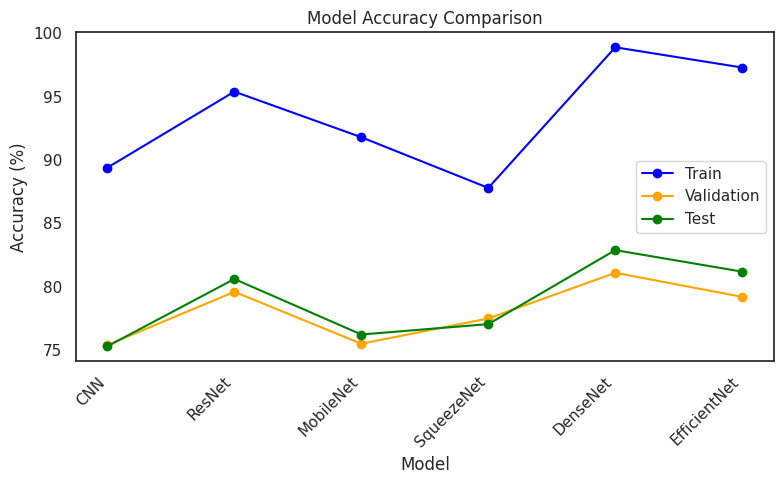

In [48]:
# Set the style of seaborn to white background without grid lines
sns.set(style="white")

plt.figure(figsize=(8, 5))

# Plot lines for Train Accuracy
plt.plot(results['Model'], results['Train Accuracy'], marker='o', label='Train', linestyle='-', color='blue')

# Plot lines for Validation Accuracy
plt.plot(results['Model'], results['Validation Accuracy'], marker='o', label='Validation', linestyle='-', color='orange')

# Plot lines for Test Accuracy
plt.plot(results['Model'], results['Test Accuracy'], marker='o', label='Test', linestyle='-', color='green')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The Model that performed better was DenseNet.

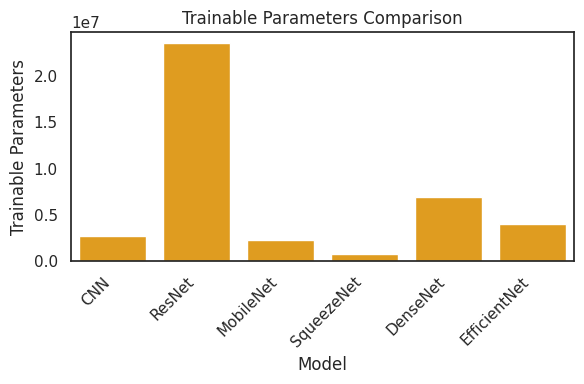

In [49]:
# Create bar chart for Trainable params
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Trainable params', data=results, color='orange')
plt.title('Trainable Parameters Comparison')
plt.ylabel('Trainable Parameters')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The model with more trainable parameters was ResNet.

## Discussion

The method used in in the paper "Thermal inspection of photovoltaic modules with deep convolutional neural networks on edge devices in AUV
Author links open overlay panel" (https://www.sciencedirect.com/science/article/pii/S0263224123006991?via%3Dihub) is different from the one implemented in this project.

The paper uses Adam optimizer with a batch size of 64 to update the model's parameters in the learning process. The learning rate was initially at 3 x 10-4 and reduced by half if the validation loss is not improved after 10 epochs. The best model was saved with a validation accuracy of 85.4% and training accuracy of 92.7%.

For this project, the optimizer that was used to update the weights of the neural network during the training process is Stochastic Gradient Descent(SGD)
with learning rate of 0.005 and momentum of 0.9.

The choice of the optimizer might impact the results. More experiment could be made in our project in order to compare the results.

While comparing training and validation accuracy we can say that the model in the paper had a validation accuracy of 85.4% and training accuracy of 92.7% while for this project we had a validation accuracy of 75.4% and training accuracy of 89.4% for CNN.


## Conclusion

Classifying anomalies in photovoltaic modules is generally not easy on the naked eye, especially when dealing with a variety of anomaly types. This project purpose an different methodologies to perform this task.

The results obtained by the implemented CNN and also for the Tranfer Learning models were very satisfying.

In the future work, improvements can be done to obtain more accurated results and also different approaches can be implemented and compared. Changes on the data augmentation like cropping, contrast, and blurring can also lead to interesting results.